# Fire weather prediction for Oregon and Washington

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

%matplotlib notebook

Using TensorFlow backend.


## Importing single location NARR-gridMET data

In [2]:
# stock_name = 'GOOGL'
# df = get_stock_data(stock_name,0)
# df.tail()

df_narr_erc = pd.read_csv('/home/dp/Documents/FWP/NARR_gridMET/csv/Training/df_NARR_gridMET_Kalmiopsis_all_years.csv', header='infer')
display('df_narr_erc head:', df_narr_erc.head(5))
display('df_narr_erc tail:', df_narr_erc.tail(5))

'df_narr_erc head:'

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
0,1979-01-02,0.742178,5715.97000,1.631845,-11.812575,102689.125,50.257525,84.694812,23.0
1,1979-01-03,1.580936,5650.36625,8.283511,-4.332774,101987.375,3.994009,73.726234,25.0
2,1979-01-04,-0.934074,5596.66250,10.444422,-2.467009,101681.250,-18.707662,-4.352164,15.0
3,1979-01-05,-0.733117,5600.45250,2.961868,-6.659581,101705.625,106.575925,162.815328,26.0
4,1979-01-06,1.559346,5585.27625,-0.860342,-5.186507,101381.375,40.390296,30.786914,28.0


'df_narr_erc tail:'

,time,noise,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
1816,1983-12-27,0.782494,5508.1800,-10.000355,-40.544150,101366.750,-53.391523,22.134313,0.0
1817,1983-12-28,-2.392586,5619.3700,-11.723684,-17.322113,102048.000,119.783963,102.634012,0.0
1818,1983-12-29,0.555242,5695.6575,0.358575,-14.475804,101878.750,-21.613663,-87.943675,0.0
1819,1983-12-30,-0.060226,5641.4650,13.035607,-20.645963,101919.875,-21.588763,-118.073588,0.0
1820,1983-12-31,-0.241805,5610.7400,2.008021,-31.701650,102444.000,-71.758150,-15.401160,0.0


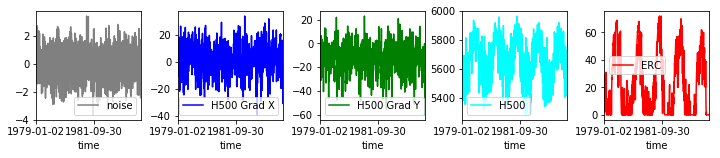

In [3]:
# Plotting ERC and H500 X gradient
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(11,2))
df_narr_erc.plot(x='time', y='noise', ax=ax0, color='gray')
df_narr_erc.plot(x='time', y='H500 Grad X', ax=ax1, color='blue')
df_narr_erc.plot(x='time', y='H500 Grad Y', ax=ax2, color='green')
df_narr_erc.plot(x='time', y='H500', ax=ax3, color='cyan')
df_narr_erc.plot(x='time', y='ERC', ax=ax4, color='red')
plt.subplots_adjust(wspace=0.35, left=0.05)
plt.show()

In [4]:
# Specify columns to train on
cols_a = ['H500','PMSL','ERC']
cols = ['H500','ERC']
cols_c = ['PMSL','ERC']
cols_d = ['H500 Grad X', 'H500 Grad Y','PMSL Grad X','PMSL Grad Y', 'ERC']
cols_e = ['noise','ERC']

df = df_narr_erc.loc[:, cols]
    
display('df to train on:', df.head(5))
n_samples = df.shape[0]
n_features = df.shape[1]-1
print('Number of samples:', n_samples)
print('Number of features:', n_features)

'df to train on:'

,H500,ERC
0,5715.97000,23.0
1,5650.36625,25.0
2,5596.66250,15.0
3,5600.45250,26.0
4,5585.27625,28.0


Number of samples: 1821
Number of features: 1


## The following is set to calculate the last feature as a result.

In [5]:
def load_data(df_fwp, seq_len):
    amount_of_features = len(df_fwp.columns)

    # We know that 'result' is the length of 'data' - 'sequence_length' (e.g. 1821 - 15 = 1806)
    # Cutting the train from test at round(0.9*1806) = 1625 + sequence_length = 1640 is all of the training data
    # This allows us scale the training and testing data before splitting the data into batches:
    data = df_fwp.values
    print('data.shape:\n', data.shape)
    print('data[:3]:\n', data[:3])
    sequence_length = seq_len + 1

    train_test_row = round(0.9*(len(data)-sequence_length))
    print('train_test_row:\n', train_test_row)

    # Scaling:
#     scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    train_temp = data[:train_test_row,:]
    print('train_temp.shape:\n', train_temp.shape)
    print('train_temp[:10]:\n', train_temp)
    print(scaler.fit(train_temp))
    data = scaler.transform(data)
    print('Scaled data:\n', data[:10])
    print('Scaler coefs:\n', scaler.scale_)
    print('--------------------------------------------')

    # Plotting hist of scaled data:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    df.hist(cols[0], bins=20, ax=ax1)
    ax2.hist(data[:,0], bins=20)
    ax1.set_title('Unscaled')
    ax2.set_title('Scaled')
    plt.show()
    
    
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    print('result.shape:', result.shape)
    print('row:', row)
    train = result[:int(row), :]
    print('train.shape:\n', train.shape)
    print('train:\n', train)
    print('********************************************')
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test, data, scaler]


## Building model functions

In [19]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.05))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.05))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d_1 = 0.05
        d_2 = 0.2
        d = 0.0001

        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

,H500,ERC
0,5715.97000,23.0
1,5650.36625,25.0
2,5596.66250,15.0
3,5600.45250,26.0
4,5585.27625,28.0
...,...,...
1816,5508.18000,0.0
1817,5619.37000,0.0
1818,5695.65750,0.0
1819,5641.46500,0.0


data.shape:
 (1821, 2)
data[:3]:
 [[5715.97      23.     ]
 [5650.36625   25.     ]
 [5596.6625    15.     ]]
train_test_row:
 1625
train_temp.shape:
 (1625, 2)
train_temp[:10]:
 [[5715.97      23.     ]
 [5650.36625   25.     ]
 [5596.6625    15.     ]
 ...
 [5813.49375   26.     ]
 [5745.47125   26.     ]
 [5655.2275    26.     ]]
MinMaxScaler(copy=True, feature_range=(0, 1))
Scaled data:
 [[0.63343041 0.31944444]
 [0.53718219 0.34722222]
 [0.45839263 0.20833333]
 [0.46395299 0.36111111]
 [0.4416877  0.38888889]
 [0.44101282 0.19444444]
 [0.42792433 0.15277778]
 [0.3955176  0.125     ]
 [0.5817733  0.06944444]
 [0.50399789 0.02777778]]
Scaler coefs:
 [0.00146711 0.01388889]
--------------------------------------------


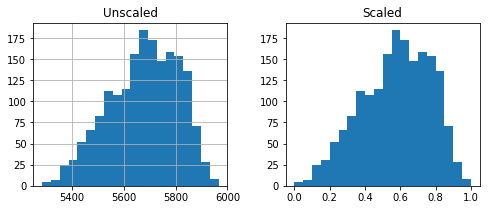

result.shape: (1806, 15, 2)
row: 1625
train.shape:
 (1625, 15, 2)
train:
 [[[0.63343041 0.31944444]
  [0.53718219 0.34722222]
  [0.45839263 0.20833333]
  ...
  [0.26450426 0.06944444]
  [0.15005098 0.06944444]
  [0.33509081 0.22222222]]

 [[0.53718219 0.34722222]
  [0.45839263 0.20833333]
  [0.46395299 0.36111111]
  ...
  [0.15005098 0.06944444]
  [0.33509081 0.22222222]
  [0.43085489 0.26388889]]

 [[0.45839263 0.20833333]
  [0.46395299 0.36111111]
  [0.4416877  0.38888889]
  ...
  [0.33509081 0.22222222]
  [0.43085489 0.26388889]
  [0.33892915 0.29166667]]

 ...

 [[0.77650893 0.36111111]
  [0.67671212 0.36111111]
  [0.5443142  0.36111111]
  ...
  [0.75258396 0.625     ]
  [0.62649096 0.44444444]
  [0.60179758 0.36111111]]

 [[0.67671212 0.36111111]
  [0.5443142  0.36111111]
  [0.59508553 0.375     ]
  ...
  [0.62649096 0.44444444]
  [0.60179758 0.36111111]
  [0.58330644 0.30555556]]

 [[0.5443142  0.36111111]
  [0.59508553 0.375     ]
  [0.59282984 0.55555556]
  ...
  [0.60179758 0.

In [20]:
window = 14
display(df)
X_train, y_train, X_test, y_test, data, scaler = load_data(df, window) # Reversing the order of the samples with [::-1]

print('data.shape:', data.shape)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

print('X_train[:3,:]:\n', X_train[:3,:])
print('y_train[:3]:\n', y_train[:3])
print('X_test[:3,:]:\n', X_test[:3,:])
print('y_test[:3]:\n', y_test[:3])

## Loading the model sequence structure

In [21]:
# model = build_model([3,lag,1])
model = build_model2([n_features+1, window, 1])

## Executing the model & RMS/RMSE results

In [30]:
t0 = time.time()

history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=150,
    validation_split=0.2, # Previous values: 0.1
    verbose=0)

t1 = time.time() - t0
print('Fit time {} minutes:', t1/60)

Fit time {} minutes: 1.2990994016329447


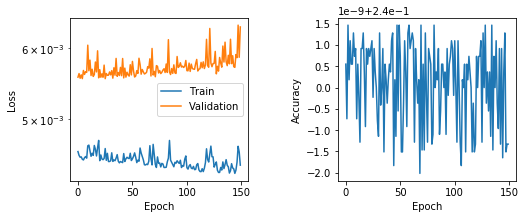

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax2.plot(history.history['acc'])
ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.subplots_adjust(wspace=0.5)
fig_str = 'FWP__RNN_metrics_w='+str(window)+'_cv=2_'+'do=0001_'+'epochs=150_'+'_'.join(cols)
plt.savefig(fig_str, bbox_inches='tight')
plt.show()

In [32]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

print('Average accuracy:', np.mean(history.history['acc']))

Train Score: 0.00 MSE (0.07 RMSE)
Test Score: 0.01 MSE (0.08 RMSE)
Average accuracy: 0.240000000111262


In [33]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

## Predictions vs Real results

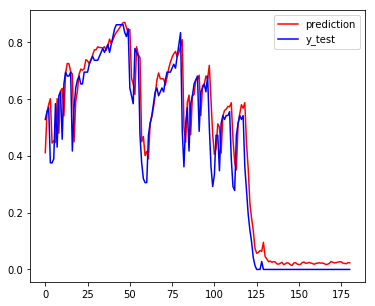

In [34]:
import matplotlib.pyplot as plt2

plt2.figure(figsize=(6,5))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper right')
plt2.show()

In [35]:
display('prediction:\n', p)
display('X_test:\n', X_test)
display('y_test:\n', y_test)

inv_y_test = y_test/scaler.scale_[n_features] # Gets the last scaler coefficient corresponding to the ERC data
# Note that inv_p = scaler.inverse_transform(p) doesn't work because scaler has two coefficients, and p is only one column of data
inv_p = p/scaler.scale_[n_features]
print('Inverse transform of y_test:\n', inv_y_test)
print('Inverse transform of predicted:\n', inv_p)

# Concatenating X_test and p to use inverse_transform won't work either because X_test contains both
# NARR variables and ERC, and in a shape that doesn't match p.

u = 10
pr = p[u][0]
print(u, y_test[u], pr, (y_test[10]/pr)-1, abs(y_test[u]- pr))

'prediction:\n'

array([[0.41102734],
       [0.55159104],
       [0.58055586],
       [0.6007249 ],
       [0.4447726 ],
       [0.4529735 ],
       [0.44613385],
       [0.60106635],
       [0.47929835],
       [0.62767726],
       [0.6373742 ],
       [0.5402832 ],
       [0.6912499 ],
       [0.7250714 ],
       [0.7237995 ],
       [0.6961424 ],
       [0.68773395],
       [0.44917446],
       [0.5912969 ],
       [0.6282741 ],
       [0.6870422 ],
       [0.70531183],
       [0.70122206],
       [0.70622057],
       [0.738414  ],
       [0.73404855],
       [0.72371656],
       [0.7385163 ],
       [0.7542147 ],
       [0.7727732 ],
       [0.77315575],
       [0.7833341 ],
       [0.78098804],
       [0.7808696 ],
       [0.77908903],
       [0.78381616],
       [0.7712241 ],
       [0.7872074 ],
       [0.8105632 ],
       [0.795438  ],
       [0.808973  ],
       [0.8237146 ],
       [0.83431655],
       [0.84191984],
       [0.85093665],
       [0.8606677 ],
       [0.86841786],
       [0.869

'X_test:\n'

array([[[0.59508553, 0.375     ],
        [0.59282984, 0.55555556],
        [0.57060489, 0.56944444],
        ...,
        [0.60179758, 0.36111111],
        [0.58330644, 0.30555556],
        [0.55347816, 0.33333333]],

       [[0.59282984, 0.55555556],
        [0.57060489, 0.56944444],
        [0.68035057, 0.41666667],
        ...,
        [0.58330644, 0.30555556],
        [0.55347816, 0.33333333],
        [0.72760083, 0.52777778]],

       [[0.57060489, 0.56944444],
        [0.68035057, 0.41666667],
        [0.61706658, 0.41666667],
        ...,
        [0.55347816, 0.33333333],
        [0.72760083, 0.52777778],
        [0.82158602, 0.55555556]],

       ...,

       [[0.65384164, 0.        ],
        [0.60114472, 0.        ],
        [0.56317396, 0.        ],
        ...,
        [0.37366493, 0.        ],
        [0.36386643, 0.        ],
        [0.32857866, 0.        ]],

       [[0.60114472, 0.        ],
        [0.56317396, 0.        ],
        [0.50042546, 0.        ],
        .

'y_test:\n'

array([0.52777778, 0.55555556, 0.56944444, 0.375     , 0.375     ,
       0.38888889, 0.58333333, 0.43055556, 0.61111111, 0.625     ,
       0.45833333, 0.65277778, 0.69444444, 0.68055556, 0.68055556,
       0.69444444, 0.41666667, 0.56944444, 0.63888889, 0.66666667,
       0.68055556, 0.65277778, 0.65277778, 0.69444444, 0.69444444,
       0.69444444, 0.72222222, 0.73611111, 0.75      , 0.73611111,
       0.73611111, 0.73611111, 0.75      , 0.76388889, 0.77777778,
       0.76388889, 0.77777778, 0.79166667, 0.76388889, 0.79166667,
       0.81944444, 0.84722222, 0.86111111, 0.86111111, 0.86111111,
       0.86111111, 0.86111111, 0.83333333, 0.81944444, 0.84722222,
       0.63888889, 0.61111111, 0.58333333, 0.77777778, 0.76388889,
       0.75      , 0.47222222, 0.375     , 0.31944444, 0.30555556,
       0.30555556, 0.47222222, 0.51388889, 0.54166667, 0.58333333,
       0.625     , 0.63888889, 0.61111111, 0.625     , 0.63888889,
       0.625     , 0.66666667, 0.69444444, 0.69444444, 0.69444

Inverse transform of y_test:
 [38. 40. 41. 27. 27. 28. 42. 31. 44. 45. 33. 47. 50. 49. 49. 50. 30. 41.
 46. 48. 49. 47. 47. 50. 50. 50. 52. 53. 54. 53. 53. 53. 54. 55. 56. 55.
 56. 57. 55. 57. 59. 61. 62. 62. 62. 62. 62. 60. 59. 61. 46. 44. 42. 56.
 55. 54. 34. 27. 23. 22. 22. 34. 37. 39. 42. 45. 46. 44. 45. 46. 45. 48.
 50. 50. 50. 51. 52. 51. 54. 57. 60. 35. 26. 37. 41. 30. 42. 44. 47. 48.
 49. 35. 45. 46. 47. 45. 49. 36. 26. 21. 24. 34. 34. 25. 37. 39. 38. 39.
 39. 40. 28. 21. 20. 34. 37. 39. 38. 39. 26. 20. 14. 10.  7.  3.  1.  0.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
Inverse transform of predicted:
 [[29.59397  ]
 [39.714554 ]
 [41.800022 ]
 [43.25219  ]
 [32.02363  ]
 [32.614094 ]
 [32.121635 ]
 [43.276775 ]
 [34.50948  ]
 [45.192764 ]
 [45.890945 ]
 [38.90039  ]
 [49.769993 ]
 [52.20514  ]
 [52.

In [36]:
print(X_test.shape)
print(y_test.shape)
print(p.shape)
print(X_test)

(181, 14, 2)
(181,)
(181, 1)
[[[0.59508553 0.375     ]
  [0.59282984 0.55555556]
  [0.57060489 0.56944444]
  ...
  [0.60179758 0.36111111]
  [0.58330644 0.30555556]
  [0.55347816 0.33333333]]

 [[0.59282984 0.55555556]
  [0.57060489 0.56944444]
  [0.68035057 0.41666667]
  ...
  [0.58330644 0.30555556]
  [0.55347816 0.33333333]
  [0.72760083 0.52777778]]

 [[0.57060489 0.56944444]
  [0.68035057 0.41666667]
  [0.61706658 0.41666667]
  ...
  [0.55347816 0.33333333]
  [0.72760083 0.52777778]
  [0.82158602 0.55555556]]

 ...

 [[0.65384164 0.        ]
  [0.60114472 0.        ]
  [0.56317396 0.        ]
  ...
  [0.37366493 0.        ]
  [0.36386643 0.        ]
  [0.32857866 0.        ]]

 [[0.60114472 0.        ]
  [0.56317396 0.        ]
  [0.50042546 0.        ]
  ...
  [0.36386643 0.        ]
  [0.32857866 0.        ]
  [0.49170713 0.        ]]

 [[0.56317396 0.        ]
  [0.50042546 0.        ]
  [0.61436892 0.        ]
  ...
  [0.32857866 0.        ]
  [0.49170713 0.        ]
  [0.6036

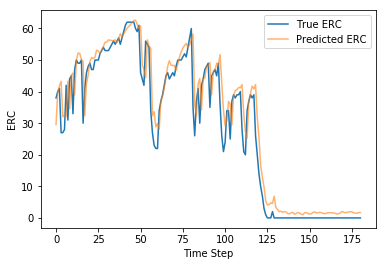

In [37]:
plt.figure()
plt.plot(inv_y_test, label='True ERC')
plt.plot(inv_p, label='Predicted ERC', alpha=0.6)
plt.legend(loc='upper right')
plt.xlabel('Time Step')
plt.ylabel('ERC')
fig_str = 'FWP__RNN_results_w='+str(window)+'_cv=2_'+'do=0001_'+'epochs=150_'+'_'.join(cols)
plt.savefig(fig_str, bbox_inches='tight')
plt.show()